In [120]:
# started here https://medium.com/@tomgrek/building-your-first-neural-net-from-scratch-with-pytorch-56b0e9c84d54

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import torch.optim as optim
import numpy as np
import copy

%matplotlib inline

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1,1024)
        self.fc2 = nn.Linear(1024,1)
    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x))))
        return x
    
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)

In [3]:
class SkipNet(nn.Module):
    def __init__(self):
        super(SkipNet, self).__init__()
        self.fc1 = nn.Linear(1,1024)
        self.fc2 = nn.Linear(1024,1)
        self.linear_gain = nn.Linear(1,1)
    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x)))) + self.linear_gain(x) 
        return x
    
skipnet = SkipNet()
skipoptimizer = optim.SGD(skipnet.parameters(), lr=0.01, momentum=0.5)

In [159]:
def criterion(out, label):
    return (label - out)**2

def skipcriterion(out, label):
    return (label - out)**2 + (torch.abs(net.fc1.weight).sum() + torch.abs(net.fc2.weight).sum()) / 2048

#data = [(1,3), (2,6), (3,9), (4,12), (5,15), (6,18)]

num_points = 100
input_data = [x for x in range(0,num_points)]
linear_data = [(3*x) for x in range(0,num_points)]
#plt.plot(input_data, linear_data)



# small experiment I ran to add a quadratic disturbance to some linear data, to see if our network can handle that
quad_points = 25
scaling_factor = .15
quad = [-scaling_factor*(x - quad_points/2)**2 + scaling_factor*(quad_points/2)**2 for x in range(0,quad_points)]

output_data = copy.deepcopy(linear_data)


start_point = 30
for i in range(0, quad_points):
    output_data[i + start_point] = linear_data[i + start_point] + quad[i]

#plt.plot(quad)
#plt.plot(output_data)

for f,b in zip(input_data,output_data):
    print(f,b)

0 0
1 3
2 6
3 9
4 12
5 15
6 18
7 21
8 24
9 27
10 30
11 33
12 36
13 39
14 42
15 45
16 48
17 51
18 54
19 57
20 60
21 63
22 66
23 69
24 72
25 75
26 78
27 81
28 84
29 87
30 90.0
31 96.6
32 102.9
33 108.9
34 114.6
35 120.0
36 125.1
37 129.9
38 134.4
39 138.6
40 142.5
41 146.1
42 149.4
43 152.4
44 155.1
45 157.5
46 159.6
47 161.4
48 162.9
49 164.1
50 165.0
51 165.6
52 165.9
53 165.9
54 165.6
55 165
56 168
57 171
58 174
59 177
60 180
61 183
62 186
63 189
64 192
65 195
66 198
67 201
68 204
69 207
70 210
71 213
72 216
73 219
74 222
75 225
76 228
77 231
78 234
79 237
80 240
81 243
82 246
83 249
84 252
85 255
86 258
87 261
88 264
89 267
90 270
91 273
92 276
93 279
94 282
95 285
96 288
97 291
98 294
99 297


In [127]:
loss_hist = []
weight_hist1 = []
weight_hist2 = []

weight_hist1.append(net.fc1.weight.clone())
for epoch in range(100):
    for i, data2 in enumerate(zip(input_data, output_data)):
        X, Y = iter(data2)
        #X, Y = Variable(torch.FloatTensor([X]), requires_grad=True).cuda(), Variable(torch.FloatTensor([Y]), requires_grad=False).cuda()
        X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)

        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.data[0])
        weight_hist1.append(net.fc1.weight.clone())
        weight_hist2.append(net.fc2.weight.clone())
        #weight_hist2.append(net.fc2.weight)
        #if (i % 10 == 0):
            #print("Epoch {} - loss: {}".format(epoch, loss.data[0]))

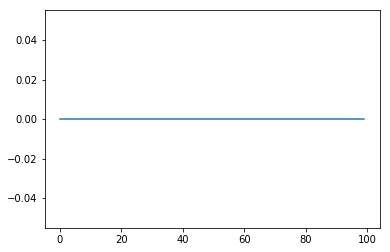

In [157]:
%matplotlib inline
#plt.plot(loss_hist[1:100], 'x-')
torch.all(torch.eq(weight_hist1[0], weight_hist1[121]))

test = net(torch.FloatTensor([1]))
test.data

output = []
for data in input_data:
    output.append(net(torch.FloatTensor([data]).data))
    
plt.plot(output)

In [9]:
# for the skip network
skip_loss_hist = []
skip_weight_hist1 = []
skip_weight_hist2 = []
skip_weight_pass_hist = []


for epoch in range(100):
    for i, data2 in enumerate(data):
        X, Y = iter(data2)
        #X, Y = Variable(torch.FloatTensor([X]), requires_grad=True).cuda(), Variable(torch.FloatTensor([Y]), requires_grad=False).cuda()
        X, Y = Variable(torch.FloatTensor([X]), requires_grad=True), Variable(torch.FloatTensor([Y]), requires_grad=False)

        skipoptimizer.zero_grad()
        outputs = skipnet(X)
        loss = skipcriterion(outputs, Y)
        loss.backward()
        skipoptimizer.step()
        
        skip_loss_hist.append(loss.data[0])
        skip_weight_hist1.append(skipnet.fc1.weight.clone())
        skip_weight_hist2.append(skipnet.fc2.weight.clone())
        skip_weight_pass_hist.append(skipnet.linear_gain.weight.clone())
        #if (i % 10 == 0):
            #print("Epoch {} - loss: {}".format(epoch, loss.data[0]))


tensor([[-0.0957],
        [ 0.3510],
        [ 0.0037],
        ...,
        [ 0.6751],
        [ 0.2107],
        [-0.3846]], grad_fn=<CloneBackward>)
tensor([[-0.0957],
        [ 0.3321],
        [ 0.0037],
        ...,
        [ 0.5661],
        [ 0.0823],
        [-0.3846]], grad_fn=<CloneBackward>)


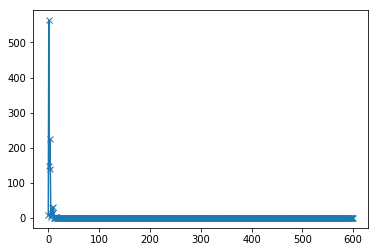

In [11]:
plt.plot(skip_loss_hist, 'x-')
print(skip_weight_hist1[0])
print(skip_weight_hist1[100])

In [20]:
import copy

print(skip_weight_hist1[1])
print(skip_weight_hist1[100])
print(skip_weight_pass_hist[100])

tensor([[ 0.2229],
        [-0.1012],
        [ 0.4080],
        ...,
        [-0.3324],
        [-0.5695],
        [ 0.6571]], requires_grad=True)
tensor([[ 0.2229],
        [-0.1012],
        [ 0.4080],
        ...,
        [-0.3324],
        [-0.5695],
        [ 0.6571]], requires_grad=True)
tensor([[2.9554]], requires_grad=True)


In [22]:
skipnet(torch.FloatTensor([5]))

tensor([15.0003], grad_fn=<ThAddBackward>)

In [ ]:
loss_hist[1:100]

In [ ]:
net

In [ ]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(1,1)
        self.fc2 = nn.Linear(1,1)
    def forward(self, x):
        x = self.fc1(x)
        return x
    
net = LinearNet()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)